# 14.5 全局向量的词嵌入（GloVe）
- **目录**
  - 14.5.1 带全局语料统计的跳元模型
  - 14.5.2 GloVe模型
  - 14.5.3 从条件概率比值理解GloVe模型


- 上下文窗口内的**词共现**可以携带丰富的**语义信息**。
  - 例如，在一个大型语料库中，“固体”比“气体”更有可能与“冰”共现，但“气体”一词与“蒸汽”的共现频率可能比与“冰”的共现频率更高。
- 此外，可以**预先**计算此类共现的全局语料库统计数据：这可以提高训练效率。
- 为了利用整个语料库中的统计信息进行词嵌入，首先回顾 14.1.3节中的跳元模型，然后使用全局语料库统计（如共现计数）来解释它。

## 14.5.1 带全局语料统计的跳元模型


用$q_{ij}$表示词$w_j$的条件概率$P(w_j\mid w_i)$，在跳元模型中给定词$w_i$，我们有：

$$q_{ij}=\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_i)}{ \sum_{k \in \mathcal{V}} \text{exp}(\mathbf{u}_k^\top \mathbf{v}_i)},\tag{14.5.1}$$

其中，对于任意索引$i$，向量$\mathbf{v}_i$和$\mathbf{u}_i$分别表示词$w_i$作为中心词和上下文词，且$\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$是词表的索引集。

考虑词$w_i$可能在语料库中出现多次（比如：I like natural language processing . I enjoy deep learning . I love machine learning .）。在整个语料库中，所有以$w_i$为中心词的上下文词形成一个词索引的**多重集**$\mathcal{C}_i$，该索引允许同一元素的多个实例。对于任何元素，其实例数称为其**重数(Multiplicity)**。举例说明，假设词$w_i$在语料库中出现两次，并且在两个上下文窗口中以$w_i$为其中心词的上下文词索引是$k, j, m, k$和$k, l, k, j$。因此，多重集$\mathcal{C}_i = \{j, j, k, k, k, k, l, m\}$，其中元素$j, k, l, m$的重数分别为2、4、1、1。

现在，让我们将多重集$\mathcal{C}_i$中的元素$j$的重数表示为$x_{ij}$。这是词$w_j$（作为上下文词）和词$w_i$（作为中心词）在整个语料库的同一上下文窗口中的**全局共现计数**。使用这样的全局语料库统计，跳元模型的损失函数等价于：
$$-\sum_{i \in \mathcal{V}} \sum_{j \in \mathcal{C}_i} \log q_{ij}$$
由于 $\mathcal{C}_i$ 是多重集，$j \in \mathcal{C}_i$ 的遍历等价于按 $x_{ij}$ 的权重求和，因此上式可改写为
$$-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij}.\tag{14.5.2}$$

我们用$x_i$表示上下文窗口中的所有上下文词的数量，其中$w_i$作为它们的中心词出现，这相当于$|\mathcal{C}_i|$。设$p_{ij}$为用于生成上下文词$w_j$的条件概率$x_{ij}/x_i$。给定中心词$w_i$， 公式14.5.2可以重写为：

$$-\sum_{i \in \mathcal{V}} x_i \sum_{j \in \mathcal{V}} \frac{x_{ij}}{x_i} \log q_{ij} = -\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.\tag{14.5.3}$$

在公式14.5.3中，<b>$-\sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}$计算全局语料统计的条件分布$p_{ij}$和模型预测的条件分布$q_{ij}$的交叉熵</b>。如上所述，这一损失也按$x_i$加权。在公式14.5.3中最小化损失函数将使预测的条件分布接近全局语料库统计中的条件分布。

虽然交叉熵损失函数通常用于测量概率分布之间的距离，但在这里可能不是一个好的选择。一方面，正如我们在14.2节中提到的，规范化$q_{ij}$的代价在于整个词表的求和，这在计算上可能非常昂贵。另一方面，来自大型语料库的大量**罕见事件**往往被交叉熵损失建模，从而赋予过多的权重。

- **要点：**
  - **跳元模型的条件概率**：在跳元模型中，给定中心词，我们可以计算其他词作为上下文词的概率。
  - **词向量表示**：在模型中，每个词有两种向量表示，一种当它作为中心词，另一种当它作为上下文词。
  - **多重集**：一个中心词在整个数据集中可能会多次出现，每次出现都有一些上下文词。这些上下文词组合起来形成了一个“多重集”。
  - **全局共现计数**：基于整个数据集，我们可以计算两个词同时作为中心词和上下文词出现的次数。
  - **跳元模型的损失函数**：这个函数希望模型预测的上下文词概率尽可能接近真实数据中的概率。
  - **重写损失函数**：为了便于计算和理解，损失函数可以被重写，考虑到每个中心词的上下文词的数量。
  - **交叉熵的问题**：虽然交叉熵是一个常用的概率分布之间的距离测量方式，但在这种情境下，它可能不是最佳选择。主要的挑战是计算上的复杂性和对于罕见事件的过高权重。

## 14.5.2 GloVe模型

GloVe模型的改进本质上是将**概率建模问题**转化为**回归问题**，通过数学变换规避了跳元模型的缺陷，简单讲就是**绕过概率，直击统计**。

GloVe也指**预训练模型**，研究者或机构（如斯坦福NLP组）通常会在大型语料库（如Wikipedia、Common Crawl）上运行GloVe算法，训练好词向量并公开。例如**glove.6B.300d.txt**在60亿词库上训练的300维词向量；**glove.840B.300d.txt**在8400亿词库上训练的300维词向量。

**GloVe**模型**基于平方损失**对跳元模型做了三个修改：
- 1. 使用变量$p'_{ij}=x_{ij}$和$q'_{ij}=\exp(\mathbf{u}_j^\top \mathbf{v}_i)$
而非概率分布，并取两者的对数。所以平方损失项是$\left(\log\,p'_{ij} - \log\,q'_{ij}\right)^2 = \left(\mathbf{u}_j^\top \mathbf{v}_i - \log\,x_{ij}\right)^2$。
- 2. 为每个词$w_i$添加两个标量模型参数：中心词偏置$b_i$和上下文词偏置$c_i$。
- 3. 用权重函数$h(x_{ij})$替换每个损失项的权重，其中$h(x)$在$[0, 1]$的间隔内递增。

整合代码，训练GloVe是为了尽量降低以下损失函数：

$$\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.\tag{14.5.4}$$


对于权重函数，建议的选择是：当$x < c$（例如，$c = 100$）时，$h(x) = (x/c) ^\alpha$（例如$\alpha = 0.75$）；否则$h(x) = 1$。在这种情况下，由于$h(0)=0$，为了提高计算效率，可以省略任意$x_{ij}=0$的平方损失项。例如，当使用小批量随机梯度下降进行训练时，在每次迭代中，我们随机抽样一小批量**非零**的$x_{ij}$来计算梯度并更新模型参数。注意，这些非零的$x_{ij}$是预先计算的全局语料库统计数据；因此，该模型GloVe被称为**全局向量**。

应该强调的是，当词$w_i$出现在词$w_j$的上下文窗口时，词$w_j$也出现在词$w_i$的上下文窗口。因此，$x_{ij}=x_{ji}$。与拟合非对称条件概率$p_{ij}$的word2vec不同，GloVe拟合对称概率$\log \, x_{ij}$。因此，在GloVe模型中，任意词的中心词向量和上下文词向量在数学上是等价的。但在实际应用中，由于初始值不同，同一个词经过训练后，在这两个向量中可能得到不同的值：GloVe将它们相加作为输出向量。

GloVe 是一种基于**全局词共现统计**的词嵌入方法，通过优化目标函数（如公式 14.5.4）学习词向量。其关键步骤包括：
- 1. **构建共现矩阵**：统计整个语料库中所有词对的共现次数 $x_{ij}$，注意共现矩阵有不同的构造方法，共现次数只是其中一种基本方法。
- 2. **优化损失函数**：最小化加权平方误差（词向量点积 + 偏置 ≈ 共现次数的对数）。
- 3. **生成词向量**：最终输出每个词的中心词向量和上下文词向量（通常取两者之和）。

GloVe是 “全局+显式”，通过共现矩阵直接建模**全局统计**，**显式优化**词向量与统计量的关系。

Word2Vec是 “局部+隐式”，通过局部窗口采样和概率优化，隐式地聚合全局信息,因为模型没有显式地拟合全局统计（如共现次数），而是通过局部上下文样本的似然最大化，间接学到词向量，其全局模式是大量局部优化的结果。

- **要点：**
  - **GloVe模型**：这是一个词嵌入模型，与word2vec的跳元模型不同，但受到其启发。
  - **三个主要修改**：
    - **非概率值**：GloVe**使用变量而非概率分布**，并取两者的对数来计算损失。
    - **偏置参数**：为每个词**引入两个偏置参数**，分别代表当该词作为中心词和上下文词时的偏置。
    - **权重函数**：使用一个权重函数来替换损失项的权重，该函数在某个范围内增加。
  - **权重函数的建议**：权重函数的设计使得**罕见词对**不会对模型产生过大的影响。
  - **训练方法**：尽管使用了全局语料库统计，但是在训练GloVe时可以使用小批量随机梯度下降，只需要在每次迭代中**随机选择**一些非零的共现次数进行计算。
  - **全局向量**：因为这些非零的共现次数是**预先从整个数据集中计算出来**的，所以GloVe模型也被称为**全局向量**。
  - **词向量的对称性**：GloVe模型中的中心词向量和上下文词向量在数学上是**等价**的，但在实际应用中可能会有所不同。在最终的应用中，通常将这**两种向量加在一起**作为词的表示。

## 14.5.3 从条件概率比值理解GloVe模型

此处内容是对Glove模型论文内容的简单解读，论文名[Glove: global vectors for word representation](https://nlp.stanford.edu/pubs/glove.pdf)。使用 14.5.1节中的相同符号，设$p_{ij} \stackrel{\mathrm{def}}{=} P(w_j \mid w_i)$为生成上下文词$w_j$的条件概率，给定$w_i$作为语料库中的中心词。下表根据大量语料库的统计数据，列出了给定单词“ice”和“steam”的共现概率及其比值。
<center>表14.5.1：大型语料库中的词-词共现概率及其比值</center>
<center><img src='../img/14_5_1.png' width=600px></center>

从上表中，我们可以观察到以下几点：

* 对于与“ice”相关但与“gas”无关的单词$w_k$，例如$w_k=\text{solid}$，我们预计会有更大的共现概率比值，例如8.9。
* 对于与“steam”相关但与“ice”无关的单词$w_k$，例如$w_k=\text{gas}$，我们预计较小的共现概率比值，例如0.085。
* 对于同时与“ice”和“steam”相关的单词$w_k$，例如$w_k=\text{water}$，我们预计其共现概率的比值接近1，例如1.36.
* 对于与“ice”和“steam”都不相关的单词$w_k$，例如$w_k=\text{fashion}$，我们预计共现概率的比值接近1，例如0.96.

由此可见，**共现概率的比值能够直观地表达词与词之间的关系**，即比值通过对比不同上下文词的条件概率，**直观量化了词语间的语义相似性或排斥性**。因此，我们可以设计三个词向量的函数来拟合这个比值。对于共现概率${p_{ij}}/{p_{ik}}$的比值，其中$w_i$是中心词，$w_j$和$w_k$是上下文词，我们**希望**使用某个函数$f$来拟合该比值：

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.\tag{14.5.5}$$


在$f$的许多可能的设计中，我们只在以下几点中选择了一个合理的选择。因为共现概率的比值是**标量**，所以我们要求$f$是标量函数，例如$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = f\left((\mathbf{u}_j - \mathbf{u}_k)^\top {\mathbf{v}}_i\right)$。这种词向量之间的差异编码可以应用在**线性类比任务**等方面，比如“国王 - 男人 + 女人 ≈ 女王”，这种差异编码非常类似概率比值。

在 公式14.5.5中交换词索引$j$和$k$，它必须保持$f(x)f(-x)=1$，即**对称性**。

所以一种可能性是$f(x)=\exp(x)$，即假设：
$$
\exp(\mathbf{u}_j^\top \mathbf{v}_i) \propto p_{ij}, \quad \exp(\mathbf{u}_k^\top \mathbf{v}_i) \propto p_{ik},
$$
则：

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.\tag{14.5.6}$$
这种函数设计满足两个要求：**标量输出**与**对称性**。

现在让我们选择$\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$，其中$\alpha$是常数。从$p_{ij}=x_{ij}/x_i$开始，取两边的对数得到$\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i$。然后使用附加的偏置项来拟合$- \log\, \alpha + \log\, x_i$，如中心词偏置$b_i$和上下文词偏置$c_j$：
$$\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log\, x_{ij}.\tag{14.5.7}$$
通过对公式14.5.7的加权平方误差的度量，得到了公式14.5.4的GloVe损失函数。该公式将词向量点积与偏置项关联到共现次数的对数，**词向量的几何空间直接反映共现强度的对数尺度**。

- **要点：**
  - **共现概率比值的观察**：基于大量语料库的统计数据，表格展示了给定“ice”和“steam”时与其他词的共现概率及其比值。
    - 与“ice”相关但与“steam”无关的词，例如"solid"，其共现概率比值较大。
    - 与“steam”相关但与“ice”无关的词，例如"gas"，其共现概率比值较小。
    - 与两者都相关的词，例如"water"，共现概率比值接近于1。
    - 与两者都不相关的词，其共现概率比值也接近于1。
  - **共现概率比值与词间关系**：共现概率的比值可以直观地显示词与词之间的关系。
  - **设计词向量的函数**：目标是找到一个函数来拟合共现概率的比值，这可以帮助我们更好地了解词与词之间的关系。
  -  **函数的选择**：虽然存在许多可能的函数设计，但选择了一个**合理的标量函数**形式。并考虑了共现概率比值为标量的事实。
  -  **拟合共现概率**：通过考虑共现概率和相关的偏置项，可以拟合观察到的共现数据，从而形成GloVe模型的基础。

-------------
- **说明：**
- **（1）公式14.5.5,14.5.6,14.5.7三个公式的推导过程及其具体涵义**
  - **公式14.5.5:**
$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}$$
    - 含义:如需用某种函数$f$，使用词向量来捕捉两个单词$w_j$和$w_k$与中心词$w_i$之间共现概率的比值。
    - 这个比值，即$\frac{p_{ij}}{p_{ik}}$，能够直观地表示$w_j$和$w_k$分别与$w_i$的关联程度。
    - 推导:这个公式并不是由某个具体的数学推导得到的，而是基于对问题的观察和理解。
    - 共现概率的比值可以表示词与词之间的关系，所以可找到一个函数来近似这个比值。
  - **公式14.5.6:**
$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}$$
    - 含义:选择一个具体的函数形式来实现上述的思想。
      - 这个函数考虑了单词$j$和$k$的词向量$\mathbf{u}_j$和$\mathbf{u}_k$，以及中心词$i$的词向量${\mathbf{v}}_i$。
      - 通过取这些向量的点积，然后使用指数函数，可以得到一个值，这个值能够近似共现概率的比值。
    - 推导:
      - 首先想要一个标量函数，所以考虑到点积是一个很好的选择。
      - 考虑到当交换词的索引时函数应该保持对称性，即$f(x)f(-x) = 1$，指数函数满足这个性质。
      - 然后选择**指数函数**来构造模型。
  - **公式14.5.7:**
    $$\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log\, x_{ij}$$
    - 含义:这个公式表示，两个单词的词向量的点积加上一些偏置项，可以近似地表示这两个单词的共现概率的对数。
    - 推导:
      - 先从公式14.5.6中的指数部分开始，有$\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$。其中，$\alpha$是一个常数。
      - 对上面的等式取对数，我们得到$\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\, \alpha + \log\, p_{ij}$。
      - 已知$p_{ij} = \frac{x_{ij}}{x_i}$，所以$\log\, p_{ij} = \log\, x_{ij} - \log\, x_i$。
      - 将上面的两个等式结合，得到$\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\, \alpha + \log\, x_{ij} - \log\, x_i$。
      - 最后引入偏置项来代表那些不容易被词向量捕捉的信息。
        - 中心词偏置$b_i$和上下文词偏置$c_j$分别表示中心词和上下文词的特定影响。
  - 综上所述，GloVe模型试图使用词向量和偏置项来近似共现概率的对数，并通过最小化预测值和真实值之间的误差来训练词嵌入。

- **（2）本节的推理过程，是不是就是为了生成可供训练的词向量模型？**
  - 在自然语言处理中，其目标是找到一种方式来表示词元，这种方式能捕获到词之间的语义关系和相似性。
    - 词向量模型，如word2vec和GloVe，都是为了这个目的而设计的。
  - 本节整个推理过程是为了构建一个可以训练的模型，这样做的主要原因是：
    - **直观的语义关系**：通过观察共现概率的比值，可以直观地捕获到词之间的关系。
      - 例如，与"ice"相关的词与与"steam"不相关的词的共现概率比值应该很大，反之亦然。
    - **可微分性**：为了训练模型，此处需要一个可微的损失函数。这就是为什么使用了函数形式，如公式$14.5.6$中的指数形式。
    - **简化和有效性**：公式$14.5.7$提供了一个简化的表达式，它将词向量、偏置项和共现频率联系起来，这样能通过梯度下降等优化算法进行有效的训练。
  - 通过上述的推理和构建，最终得到了一个模型，该模型旨在最小化预测的共现概率与实际共现概率之间的差异。
    - 当模型被有效地训练后，词向量应该能够捕获词汇的丰富语义关系，并可以在各种自然语言处理任务中使用。
-------------

## 小结

* 诸如词-词共现计数的全局语料库统计可以来解释跳元模型。
* 交叉熵损失可能不是衡量两种概率分布差异的好选择，特别是对于大型语料库。GloVe使用平方损失来拟合预先计算的全局语料库统计数据。
* 对于GloVe中的任意词，中心词向量和上下文词向量在数学上是等价的。
* GloVe可以从词-词共现概率的比率来解释。

---------------
- **附录：GloVe算法实现代码**
  - 使用14.4节的词嵌入训练数据集PTB

Epoch 9, Loss: 0.0061

Similar words to 'chip':
cosine sim=0.644: intel
cosine sim=0.552: microprocessor
cosine sim=0.428: mips


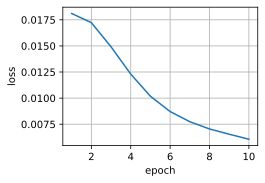

In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
from collections import defaultdict

# 加载PTB数据集
batch_size, max_window_size = 512, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words=0)

# GloVe超参数
embed_size = 100
x_max = 100  # 权重函数截断阈值
alpha = 0.75  # 权重函数幂次
lr = 0.05
num_epochs = 10

class GloVeModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        # 中心词和上下文词向量
        self.center_embeddings = nn.Embedding(vocab_size, embed_size)
        self.context_embeddings = nn.Embedding(vocab_size, embed_size)
        # 偏置项
        self.center_biases = nn.Embedding(vocab_size, 1)
        self.context_biases = nn.Embedding(vocab_size, 1)
        
        # 初始化参数
        nn.init.uniform_(self.center_embeddings.weight, -0.5/embed_size, 0.5/embed_size)
        nn.init.uniform_(self.context_embeddings.weight, -0.5/embed_size, 0.5/embed_size)
        nn.init.zeros_(self.center_biases.weight)
        nn.init.zeros_(self.context_biases.weight)
    
    def forward(self, center, context):
        # 计算点积 + 偏置（对应公式14.5.4）
        v = self.center_embeddings(center)  # shape: (batch_size, embed_size)
        u = self.context_embeddings(context) # shape: (batch_size, embed_size)
        b = self.center_biases(center).squeeze(1) # shape: (batch_size,)
        c = self.context_biases(context).squeeze(1)
        return (v * u).sum(dim=1) + b + c  # shape: (batch_size,)

# 构建共现矩阵
def build_cooccurrence_matrix(vocab, data_iter):
    token_to_idx = vocab.token_to_idx
    cooccur = defaultdict(float)
    
    for batch in data_iter:
        centers, contexts, _, labels = batch
        for center, context_window, label_mask in zip(centers, contexts, labels):
            center_idx = center.item()
            # 过滤噪声词和填充符，保留真实上下文词及其原始位置信息
            real_contexts = [(pos, c.item()) for pos, (c, label) in 
                           enumerate(zip(context_window, label_mask)) 
                           if label == 1 and c != 0]
            
            if not real_contexts:
                continue
                
            # 计算中心词在context_window中的理论位置
            total_contexts = len(context_window)
            center_pos_in_window = total_contexts // 2  # 上下文词围绕中心词对称排列
            
            for original_pos, context_idx in real_contexts:
                # 计算实际距离（考虑左右窗口）
                if original_pos < center_pos_in_window:
                    # 左窗口词：距离 = 中心位置 - 当前索引
                    distance = center_pos_in_window - original_pos
                else:
                    # 右窗口词：距离 = 当前索引 - 中心位置 + 1
                    distance = original_pos - center_pos_in_window + 1
                
                weight = 1.0 / distance
                cooccur[(center_idx, context_idx)] += weight
                cooccur[(context_idx, center_idx)] += weight  # 维持对称性
    
    # 转换为稀疏张量格式
    center_indices, context_indices, x_ij = [], [], []
    for (i, j), count in cooccur.items():
        center_indices.append(i)
        context_indices.append(j)
        x_ij.append(count)
    
    return (torch.LongTensor(center_indices),
            torch.LongTensor(context_indices),
            torch.FloatTensor(x_ij))

# 权重函数
def weight_func(x):
    return (x / x_max) ** alpha if x < x_max else 1.0

# 训练函数
def train_glove(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    net = net.to(device)
    optimizer = torch.optim.Adagrad(net.parameters(), lr=lr)  # GloVe常用Adagrad
    
    # 预计算共现矩阵
    print("构建共现矩阵...")
    center_idx, context_idx, x_ij = build_cooccurrence_matrix(vocab, data_iter)
    log_x_ij = torch.log(x_ij + 1e-8)  # 避免log(0)
    weights = torch.FloatTensor([weight_func(x) for x in x_ij])
    
    # 转换为设备张量
    center_idx = center_idx.to(device)
    context_idx = context_idx.to(device)
    log_x_ij = log_x_ij.to(device)
    weights = weights.to(device)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss')
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = net(center_idx, context_idx)
        loss = (weights * (pred - log_x_ij) ** 2).mean()  # 公式14.5.4
        loss.backward()
        optimizer.step()
        
        animator.add(epoch + 1, (loss.item(),))
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 初始化并训练模型
vocab_size = len(vocab)
net = GloVeModel(vocab_size, embed_size)
train_glove(net, data_iter, lr, num_epochs)

# 获取最终词向量（中心+上下文向量平均）
combined_embeddings = (net.center_embeddings.weight.data + 
                       net.context_embeddings.weight.data) / 2

# 相似词查询
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data if hasattr(embed, 'weight') else embed
    x = W[vocab[query_token]]
    cos = torch.mv(W, x) / (torch.norm(W, dim=1) * torch.norm(x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 排除输入词本身
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

# 测试相似词查询
print("\nSimilar words to 'chip':")
get_similar_tokens('chip', 3, combined_embeddings)

In [ ]:
# 全局词嵌入的形状以及某个词向量示例
combined_embeddings.shape,combined_embeddings[0]

------------